In [3]:
import warnings
warnings.filterwarnings("ignore")
import torch
import networkx as nx
import os 
import sys
from evaluation.mol_structure import list_of_smiles_to_nx_graphs
#from evaluation.mol_structure import draw_one_mol, draw_graphs
#from evaluate import evaluate
#import utils.graph_generators as gen

current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
import rdkit
import numpy as np
from evaluation.utils import get_data
import json
from evaluation.moses.metrics.utils  import logP, QED, SA
from rdkit import Chem
import pandas as pd
from rdkit import RDLogger 


In [4]:
from rdkit import Chem
from rdkit.Chem import GetFormalCharge
from collections  import defaultdict
import rdkit
smiles='O[C@@](CCN1CCCC1)(c1ccccc1)C1CCCCC1'
m = Chem.MolFromSmiles(smiles)
def composition(molecule):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule_with_Hs = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule_with_Hs.GetAtoms():
            comp[atom.GetAtomicNum()] += 1

        # If charged, add charge as "atomic number" 0
        charge = GetFormalCharge(molecule_with_Hs)
        if charge != 0:
            comp[0] = charge
        return comp
composition(m)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {8: 1, 6: 19, 7: 1, 1: 29})

In [26]:
smiles='C[C@@H]1O[C@H](O[C@@H]2CC[C@@]3(C=O)[C@H]4CC[C@@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@@]5(O)[C@@H]4CC[C@]3(O)C2)C[C@H](O)[C@@H]1O'
smiles='C[SiH2][Cu]'
smiles='F'
smiles='CN[Cu](C)([Cu])([SeH])P[Mn].C[IH]N.C[Ni](N)O.N.NP.PI.P[Cu].P[Ni].[CaH][Pt].[Fe][Pt].[Fe][Se][Ni].[K][Pt].[Li]C.[Ni].[Pt]'
m = Chem.MolFromSmiles(smiles)


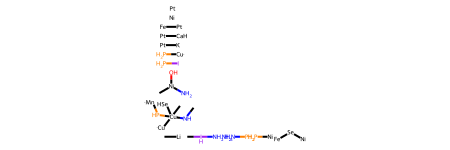

In [27]:
m

In [13]:
dir(Draw)

['BytesIO',
 'Chem',
 'ContourAndDrawGaussians',
 'ContourAndDrawGrid',
 'ContourParams',
 'DrawMoleculeACS1996',
 'DrawMorganBit',
 'DrawMorganBits',
 'DrawMorganEnv',
 'DrawMorganEnvs',
 'DrawRDKitBit',
 'DrawRDKitBits',
 'DrawRDKitEnv',
 'DrawRDKitEnvs',
 'DrawingOptions',
 'FingerprintEnv',
 'IPythonConsole',
 'IntStringMap',
 'InteractiveRenderer',
 'MeanBondLength',
 'MolDraw2D',
 'MolDraw2DCairo',
 'MolDraw2DSVG',
 'MolDrawOptions',
 'MolDrawing',
 'MolToACS1996SVG',
 'MolToFile',
 'MolToImage',
 'MolToImageFile',
 'MolToMPL',
 'MolToQPixmap',
 'MolToSVG',
 'MolsToGridImage',
 'MolsToImage',
 'PrepareAndDrawMolecule',
 'PrepareMolForDrawing',
 'RDConfig',
 'ReactionToImage',
 'SetACS1996Mode',
 'SetComicMode',
 'SetDarkMode',
 'SetMonochromeMode',
 'ShowMol',
 'UpdateDrawerParamsFromJSON',
 'UpdateMolDrawOptionsFromJSON',
 '_MolsToGridImage',
 '_MolsToGridSVG',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__s

In [2]:
def get_data(name, path='data/smiles/',return_smiles=False):
    splits={}
    RDLogger.EnableLog('rdApp.*')
    RDLogger.DisableLog('rdApp.*')  
    split_names=[ 'train1_pos_smiles','train1_neg_smiles','test_smiles','test_targets' ]
    for i,split in enumerate(split_names):
        exact_path=path+'{}/{}.txt'.format(name, split)
        #from data.smiles.carcinogens import test_smiles
        current_list = []
        with open(exact_path) as my_file:
         for line in my_file:
            current_list.append(line.strip())
        splits[split]=current_list     
    return splits
    

In [102]:
def get_data(name, path='data/smiles/',return_smiles=False):
    
    RDLogger.EnableLog('rdApp.*')
    RDLogger.DisableLog('rdApp.*')  
   
    exact_path1=path+'{}/{}.txt'.format(name, split)
    exact_path2=path+'{}/{}.txt'.format(name, split)
    #from data.smiles.carcinogens import test_smiles
    smiles = []
    with open(exact_path) as my_file:
        for line in my_file:
         smiles.append(line.strip())
    with open(exact_path) as my_file:
        for line in my_file:
         smiles.append(line.strip())
    return smiles
    

In [3]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
dataset_name='lipophilicity_astrazeneca'
splits=get_data(dataset_name ,return_smiles=True)

In [63]:
        
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
dataset_name='lipophilicity_astrazeneca'
splits=get_data(dataset_name ,return_smiles=True)


In [94]:
train1_pos_smiles,train1_neg_smiles, test_smiles, test_targets=splits['train1_pos_smiles'], splits['train1_neg_smiles'],splits['test_smiles'],splits['test_targets']
test_pos=[x for x, y in zip(splits['test_smiles'],splits['test_targets']) if y=='1.0']
test_neg=[x for x, y in zip(splits['test_smiles'],splits['test_targets']) if y=='0.0']
test_neg

['CNc1cccc(CCCc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)C(=O)O)s2)n1',
 'CC(C)NC(=O)c1cc2c(-n3ccc(C(F)(F)F)n3)c(-c3cncc(C(=O)O)c3)cnc2[nH]1',
 'C(=C/c1nn[nH]n1)\\c1ccccc1',
 'COc1ccc2nnc(=O)n(CCN3CCC(NCc4ccc5c(n4)NC(=O)CO5)CC3)c2c1',
 'O=S(=O)(NCCNc1ncccn1)c1cccc2cnccc12',
 'CCC(c1nc2ncccc2c(=O)n1Cc1ccccc1)N(CCCN)C(=O)c1ccc(C)cc1',
 'CC1Sc2c(C(=O)O)c(=O)c3cc(F)c(N4CCNCC4)cc3n21',
 'O=C(O)CN1C(=O)C(NC(=O)c2cc3sc(Cl)c(Cl)c3[nH]2)Cc2ccccc21',
 'C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c3c2F)C[C@@H](C)N1',
 'CCC(C)NC(=O)c1c(C)nn(-c2ccccc2)c1NS(=O)(=O)c1ccc(C)cc1',
 'O=C(N[C@@H](Cc1ccc(C#CCCNc2ccccn2)cc1)C(=O)O)c1c(Cl)cccc1Cl',
 'CCN1CCCC1CNC(=O)c1cc(S(N)(=O)=O)ccc1OC',
 'CC[C@H]1CN(Cc2cc(Cl)ccc2OCC(=O)O)CCN1S(=O)(=O)c1ccccc1',
 'O=c1cc(N2CCOCC2)oc2cc(O)ccc12',
 'CCC1(C)CC(=O)NC1=O',
 'CNc1cccc(CCCc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)C(=O)O)cc2)n1',
 'N#Cc1ccc2ccc(=O)n(CCN3CC[C@H](NCc4ccc5c(n4)NC(=O)CO5)[C@H](O)C3)c2c1',
 'Nc1ccnc(-c2cccnc2)n1',
 'CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=O)cc

In [95]:
splits['test_targets'][0]=='1.0'


True

In [96]:

data=train1_pos_smiles+test_pos
mols =[Chem.MolFromSmiles(smiles)  for smiles in data]
log_p =[logP(mol) for mol in mols]
qeds= [QED(mol) for mol in mols]
sas= [SA(mol) for mol in mols]
d1={'smiles':data,'logP':log_p, 'qed':qeds,'SAS':sas}
trial=pd.DataFrame(data=d1)
trial.to_csv('{}_train1_pos.csv'.format(dataset_name), index=True)

In [97]:
data2=train1_neg_smiles+test_neg
mols =[Chem.MolFromSmiles(smiles)  for smiles in data2]
log_p =[logP(mol) for mol in mols]
qeds= [QED(mol) for mol in mols]
sas= [SA(mol) for mol in mols]
d2={'smiles':data2,'logP':log_p, 'qed':qeds,'SAS':sas}
trial=pd.DataFrame(data=d2)
trial.to_csv('{}_train1_neg.csv'.format(dataset_name), index=True)

In [98]:
valid_idx_pos=list(np.arange (len(train1_pos_smiles), len(train1_pos_smiles)+ len(test_pos)))
valid_idx_pos_=[str(i) for i in valid_idx_pos]
valid_idx_neg=list(np.arange (len(train1_neg_smiles), len(train1_neg_smiles)+ len(test_neg)))
valid_idx_neg_=[str(i) for i in valid_idx_neg]

In [99]:
dict={"valid_idxs":valid_idx_pos_}
with open("valid_idx_{}_train1_pos.json".format(dataset_name), "w") as outfile:
    json.dump(dict, outfile)


In [100]:
dict={"valid_idxs":valid_idx_neg_}
with open("valid_idx_{}_train1_neg.json".format(dataset_name), "w") as outfile:
    json.dump(dict, outfile)
